In [1]:
!pip install tensorflow==2.9.0

# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previus notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.


## Creating helper funtions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or else where).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-12-18 14:15:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-18 14:15:43 (20.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑**Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pre-trained models within `tf.keras.aplications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=en

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-12-18 14:15:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   149MB/s    in 1.1s    

2024-12-18 14:15:51 (149 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [7]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                             label_mode="categorical",
                                                                             batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[219.84183    108.841835   117.841835  ]
   [223.16837    113.168365   122.168365  ]
   [219.78572    110.42857    121.21429   ]
   ...
   [227.28572    223.28572    224.28572   ]
   [226.64285    222.64285    223.64285   ]
   [226.64285    222.64285    223.64285   ]]

  [[223.09184    111.091835   123.091835  ]
   [226.64287    114.64285    126.64285   ]
   [220.17346    110.602036   122.03061   ]
   ...
   [226.08673    222.08673    223.08673   ]
   [225.13776    221.13776    222.13776   ]
   [224.14285    220.14285    221.14285   ]]

  [[221.57652    106.57653    121.57653   ]
   [221.38776    109.341835   123.35714   ]
   [221.         111.         124.        ]
   ...
   [226.21428    219.57143    219.78572   ]
   [226.44388    219.80103    220.0153    ]
   [226.64285    220.         220.21428   ]]

  ...

  [[238.92862    217.35715    219.14288   ]
   [237.57147    216.         217.78574   ]
   [236.61734    215.04587    216.8316    ]
   ...
   [174.9746     153.122

The **Funtional API** is more flexible than the **Keras Sequential**.

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequetial order.

But the functional API gives us more flexibility with our models.

If you do run into error, such as your model nor learning anything, one of the biggest things will be to look to see if your inputs into the model are the same as what the model has trained on. (step 4 from the code below)

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20241218-141601
Epoch 1/5
24/24 [==============================] - 80s 3s/step - loss: 1.8742 - accuracy: 0.4547 - val_loss: 1.2908 - val_accuracy: 0.7648
Epoch 2/5
24/24 [==============================] - 71s 3s/step - loss: 1.1372 - accuracy: 0.7867 - val_loss: 0.8741 - val_accuracy: 0.8273
Epoch 3/5
24/24 [==============================] - 57s 2s/step - loss: 0.8305 - accuracy: 0.8267 - val_loss: 0.6853 - val_accuracy: 0.8684
Epoch 4/5
24/24 [==============================] - 72s 3s/step - loss: 0.6960 - accuracy: 0.8480 - val_loss: 0.5989 - val_accuracy: 0.8783
Epoch 5/5
24/24 [==============================] - 72s 3s/step - loss: 0.5904 - accuracy: 0.8640 - val_loss: 0.5425 - val_accuracy: 0.8832


In [12]:
#Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 104s 1s/step - loss: 0.5658 - accuracy: 0.8600


[0.5657546520233154, 0.8600000143051147]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [14]:
# summary of the base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

In [15]:
# Summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


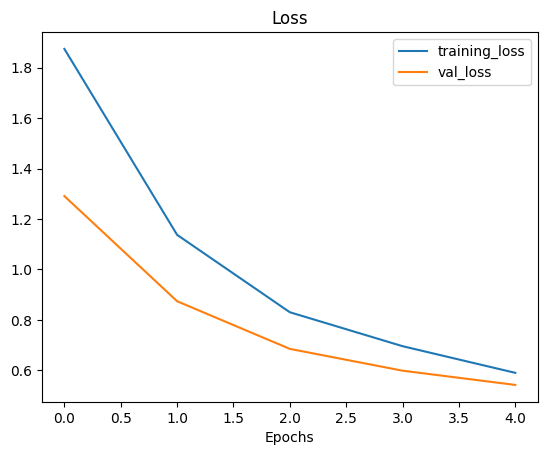

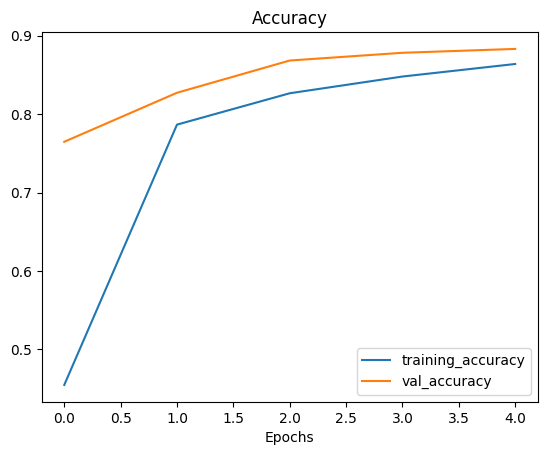

In [16]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7,7,1280)...

But then when it passes through GlobalAveragePooling 2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4,4,3) and then pass it to GlobalAveragePooling2D.

> What the GlobalAveragePooling2D does is condenses the tensor into a smaller vector, and then that vector is the input to our final dense layer.

In [17]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor} ")

# Pass the random tensor through a global average pooling 2D
global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooling_tensor}")

# Check the shape of the differente tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled 2D tensor: {global_average_pooling_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]] 
2D global average pooled random tensor: 
 [[-0.09368646 -0.45840445 -0.28855976]]
Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2D tensor: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens if pretrained model outputs a **feature vector** (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can be then be used to extract patterns out for our own specific problems.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning tranfer leanring on 100% of the training data with data augmentation.

> 🔑 **Note:** throughout all experiments the same dataset will be used to evaluate our model... this ensures  consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [19]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-12-18 14:24:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 74.125.137.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   261MB/s    in 0.5s    

2024-12-18 14:24:27 (261 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [20]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [21]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

In [22]:
# Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


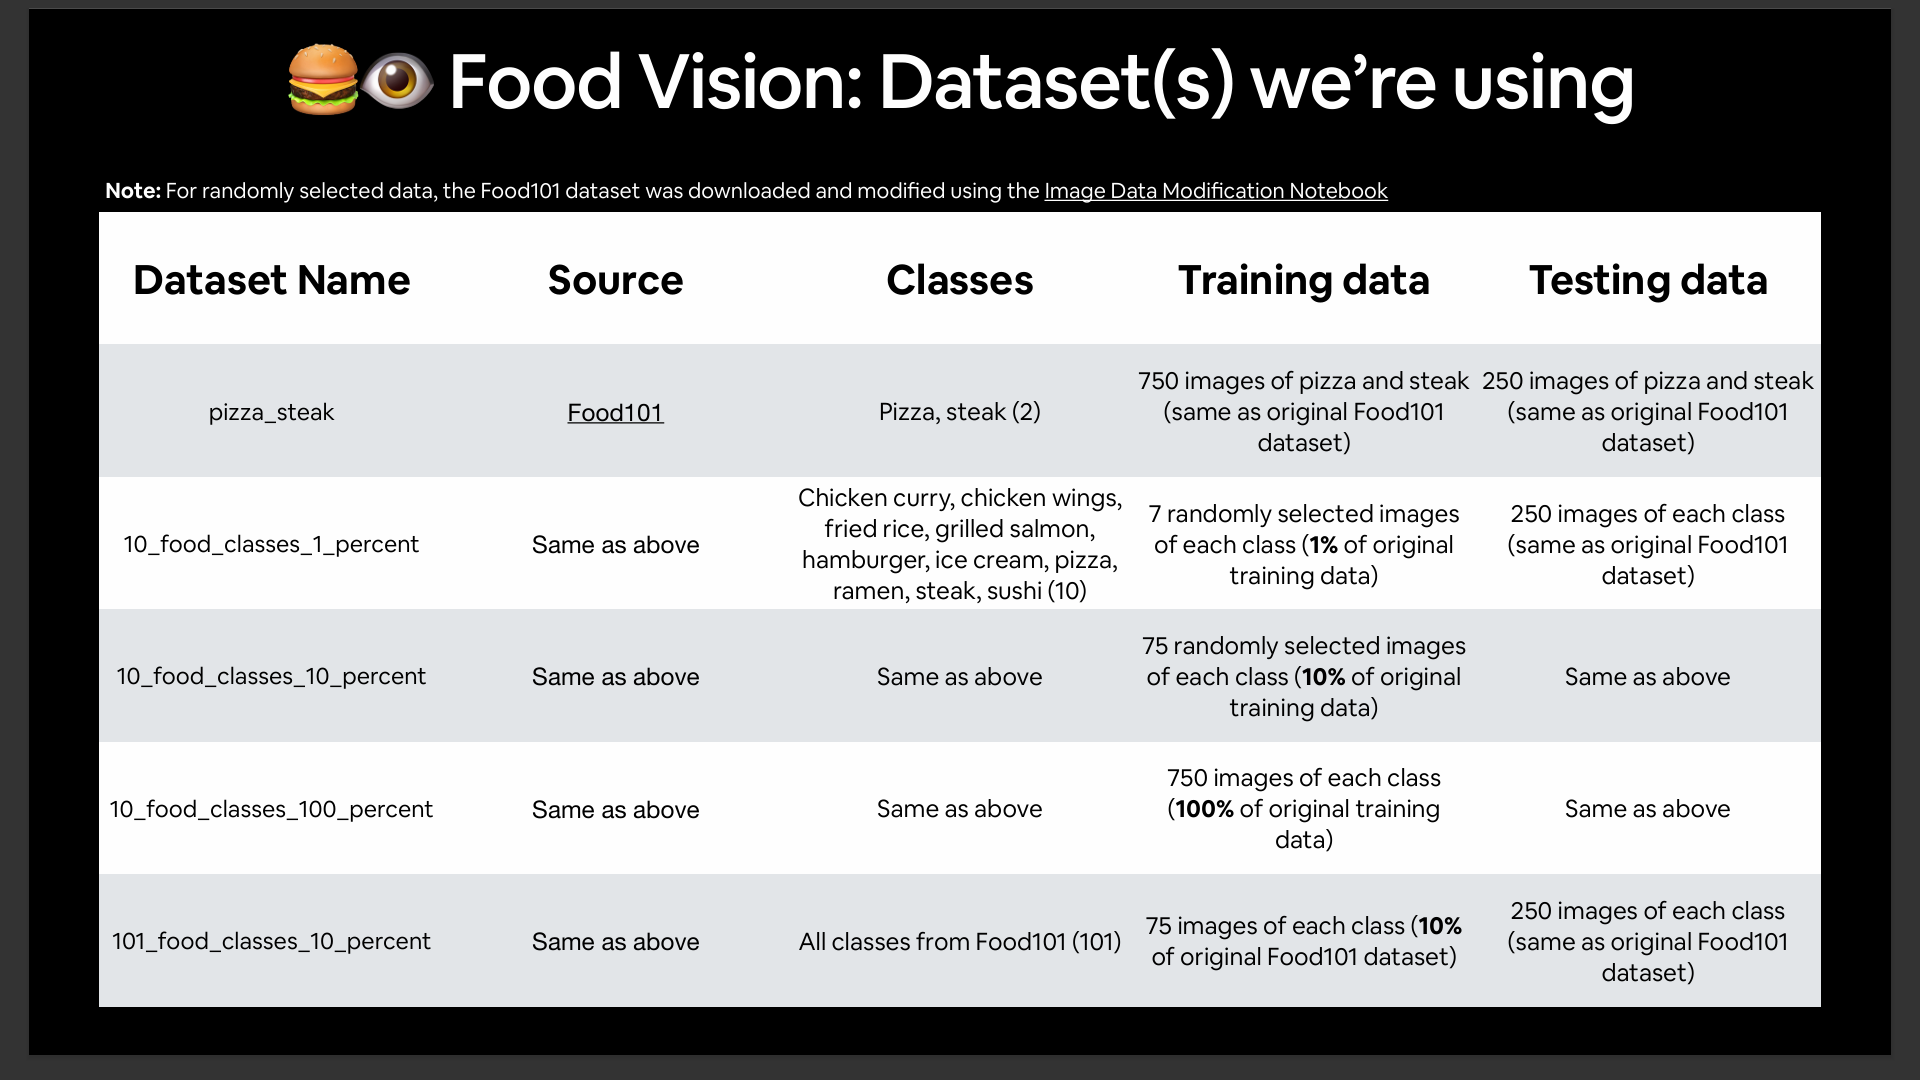

### Adding data augmentation right into the model

To add data augmenation right into our models, we can use the layers inside:

* `tf.keras.layer.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data aumgentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top our head, after reading the docs, the beneficts of using data aumgnetation insie the mdoel are:
* Preprocessing of images (augmenting them) hapens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
   layers.RandomFlip("horizontal"),
   layers.RandomRotation(0.2),
   layers.RandomZoom(0.2),
   layers.RandomHeight(0.2),
   layers.RandomWidth(0.2),
   # preprocessing.Rescaling(1./255) # Keep for models like ResNet50v2 but remove EfficientNetV2B0
], name="data_augmentation")

### Visualize our data augmenation layer (and see what happens to our data)

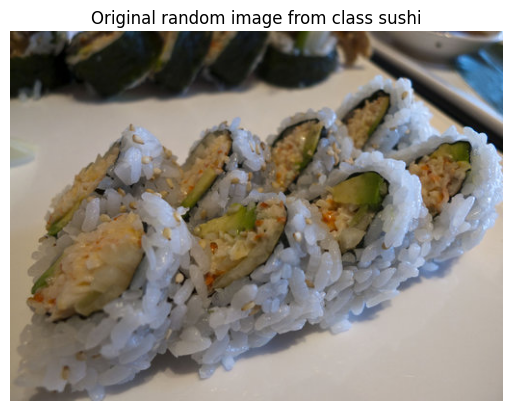

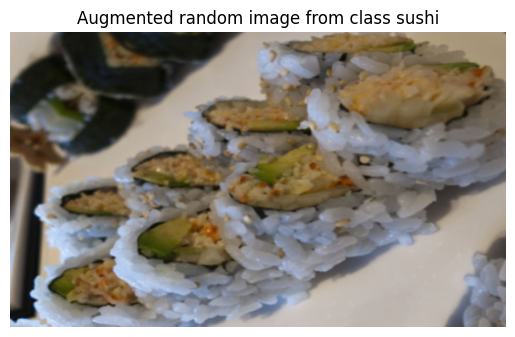

In [24]:
#View a random image and compare to its augmenation
import matplotlib.pyplot as plt
import matplotlib.image as mp
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mp.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_image = data_augmentation(tf.expand_dims(img,axis=0), training = True)
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f"Augmented random image from class {target_class}")
plt.axis(False);

### Model_1: Feature extraction transfer learning on 1% of the data with data augmentation

In [25]:
# Set up input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmenation Sequential model as layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmenation) and don't train it
x = base_model(x, training=False)

# Pool output feautres of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layers on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_1_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        # Track model training logs
                        callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                 experiment_name = "1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20241218-142436
Epoch 1/5
3/3 [==============================] - 53s 23s/step - loss: 2.4204 - accuracy: 0.0714 - val_loss: 2.2590 - val_accuracy: 0.1431
Epoch 2/5
3/3 [==============================] - 44s 21s/step - loss: 2.1322 - accuracy: 0.2143 - val_loss: 2.1310 - val_accuracy: 0.2566
Epoch 3/5
3/3 [==============================] - 28s 13s/step - loss: 2.0444 - accuracy: 0.2429 - val_loss: 2.0188 - val_accuracy: 0.3520
Epoch 4/5
3/3 [==============================] - 28s 13s/step - loss: 1.8406 - accuracy: 0.4571 - val_loss: 1.9412 - val_accuracy: 0.3783
Epoch 5/5
3/3 [==============================] - 44s 21s/step - loss: 1.7161 - accuracy: 0.5286 - val_loss: 1.8552 - val_accuracy: 0.4326


In [26]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [27]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 99s 1s/step - loss: 1.8658 - accuracy: 0.4176


[1.865838885307312, 0.41760000586509705]

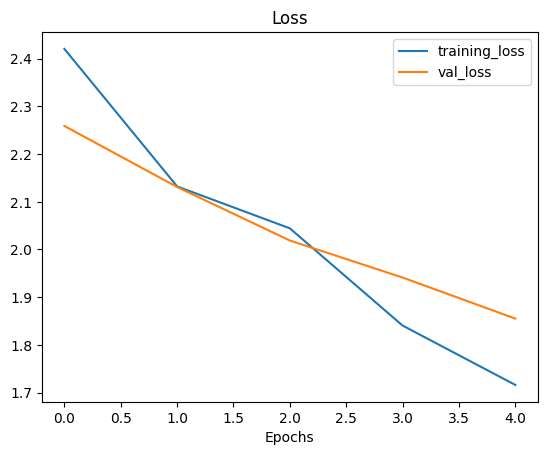

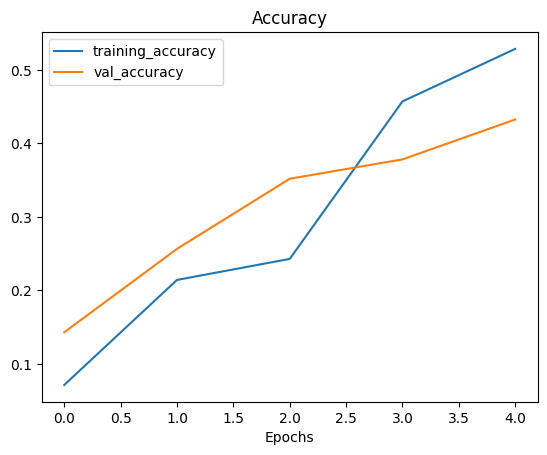

In [28]:
# How do the model with 1% of the data and dat augmenation loss curves look
plot_loss_curves(history_1)

## Model 2: feature extraction transfer learning model with 10% of data augmentation

In [29]:
# Get 10% of data...
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [30]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [31]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmenation layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
], name = "data_augmentation")

# Set up the input shape to our model
input_shape = (224,224,3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False) #pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


### Creating a ModelCheckpoint Callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during trainign. This is useful so we can come and start where we left off.

In [32]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a modelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weigths_only = True,
                                                         save_best_only = False,
                                                         save_freque="epochs", #save every epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [33]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                 experiment_name="10_percent_data_aug"),

                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20241218-143123
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0377 - accuracy: 0.2853
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


24/24 [==============================] - 128s 5s/step - loss: 2.0377 - accuracy: 0.2853 - val_loss: 1.5229 - val_accuracy: 0.6431
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4499 - accuracy: 0.6000
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


24/24 [==============================] - 104s 4s/step - loss: 1.4499 - accuracy: 0.6000 - val_loss: 1.0652 - val_accuracy: 0.7648
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1337 - accuracy: 0.7280
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


24/24 [==============================] - 123s 5s/step - loss: 1.1337 - accuracy: 0.7280 - val_loss: 0.8500 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.9555 - accuracy: 0.7613
Epoch 4: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


24/24 [==============================] - 108s 5s/step - loss: 0.9555 - accuracy: 0.7613 - val_loss: 0.7198 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.8250 - accuracy: 0.8013
Epoch 5: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


24/24 [==============================] - 110s 5s/step - loss: 0.8250 - accuracy: 0.8013 - val_loss: 0.6442 - val_accuracy: 0.8322


In [34]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 103s 1s/step - loss: 0.5658 - accuracy: 0.8600


[0.5657547116279602, 0.8600000143051147]

In [35]:
# Check model_2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 104s 1s/step - loss: 0.6596 - accuracy: 0.8332


[0.6595634818077087, 0.8331999778747559]

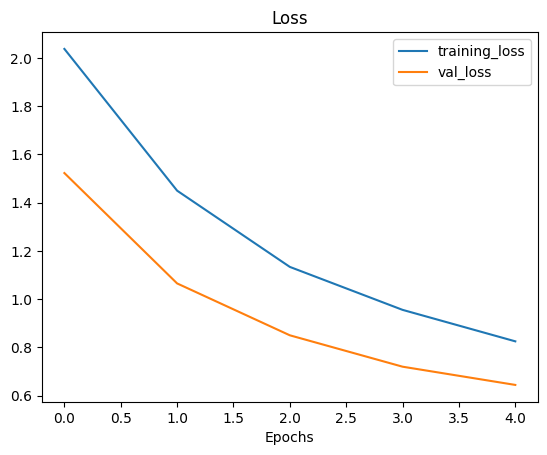

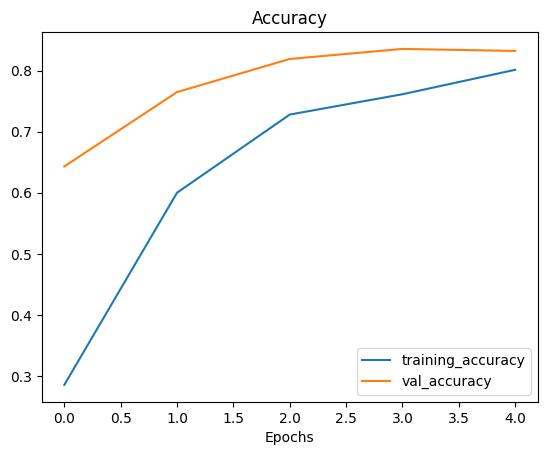

In [36]:
# Plot model loos curves
plot_loss_curves(history_2)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [37]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [38]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 102s 1s/step - loss: 0.6596 - accuracy: 0.8332


In [39]:
# If the results from our previously evaluated model_2 match the loaded weights , everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [40]:
results_10_percent_data_aug

[0.6595634818077087, 0.8331999778747559]

In [41]:
loaded_weights_model_results

[0.6595633625984192, 0.8331999778747559]

In [42]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [43]:
# Check the difference between the two results
print (np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.1920929e-07 0.0000000e+00]


## Model 3: Fine-tuning an exisitng model on 10% of the data

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [44]:
# Layers in our loaded model
model_2.layers

In [45]:
# Are these layers trainable?
for layers in model_2.layers:
  print(layer, layer.trainable)

<keras.layers.core.activation.Activation object at 0x7f3397f19900> False
<keras.layers.core.activation.Activation object at 0x7f3397f19900> False
<keras.layers.core.activation.Activation object at 0x7f3397f19900> False
<keras.layers.core.activation.Activation object at 0x7f3397f19900> False
<keras.layers.core.activation.Activation object at 0x7f3397f19900> False


In [46]:
# What layers are in our base_model and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [47]:
# how may trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [48]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base model.trainable=True
base_model.trainable = True

# Freeze all layer excepct for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change )
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])


> 🔑 **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune.Buta good rule of thumb is at least 10x (though different sources will claim other values).

In [49]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [50]:
# Now we've unfrozeen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [51]:
# Fine tune for another 5 epochs
fine_tune_epochs =initial_epochs + 5

# Refit the model(same as model_2 expcet with more trainable layers)
history_2_fine = model_2.fit(train_data_10_percent,
                             epochs= fine_tune_epochs,
                             validation_data = test_data,
                             validation_steps= int(0.25*len(test_data)),
                             initial_epoch = history_2.epoch[-1], #start training from the previous last epoch
                             callbacks =[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name = "10_percent_fine_tune_last_10")] )

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20241218-144752
Epoch 5/10
24/24 [==============================] - 93s 4s/step - loss: 0.7059 - accuracy: 0.8120 - val_loss: 0.4977 - val_accuracy: 0.8487
Epoch 6/10
24/24 [==============================] - 79s 3s/step - loss: 0.5919 - accuracy: 0.8213 - val_loss: 0.4154 - val_accuracy: 0.8684
Epoch 7/10
24/24 [==============================] - 66s 3s/step - loss: 0.5279 - accuracy: 0.8280 - val_loss: 0.4109 - val_accuracy: 0.8586
Epoch 8/10
24/24 [==============================] - 66s 3s/step - loss: 0.5294 - accuracy: 0.8360 - val_loss: 0.4163 - val_accuracy: 0.8586
Epoch 9/10
24/24 [==============================] - 62s 3s/step - loss: 0.4633 - accuracy: 0.8493 - val_loss: 0.3931 - val_accuracy: 0.8783
Epoch 10/10
24/24 [==============================] - 83s 3s/step - loss: 0.4567 - accuracy: 0.8587 - val_loss: 0.3738 - val_accuracy: 0.8799


In [52]:
# Evaluate the fine-tuned model (model_3 which is actuallu model_2 fine-tuned for another 5  epochs)
results_fine_tune_10_percent= model_2.evaluate(test_data)
results_fine_tune_10_percent

79/79 [==============================] - 101s 1s/step - loss: 0.4392 - accuracy: 0.8564


[0.43915048241615295, 0.8564000129699707]

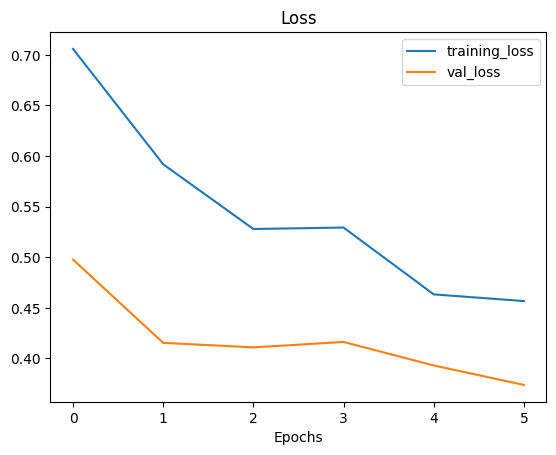

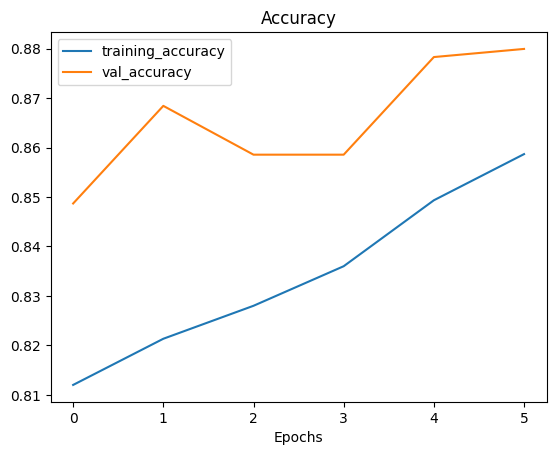

In [53]:
# Check out the loss curves
plot_loss_curves(history_2_fine)

The `plot_loss_curves` function works great with model which have only been fit one, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [54]:
# Let's createa function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compare two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = acc + new_history.history["val_accuracy"]
  total_val_loss = loss + new_history.history["val_loss"]

  # Make plots
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation accuracy")

  # Make plot loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

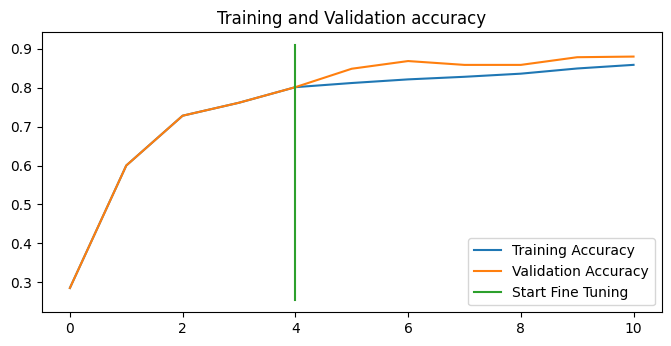

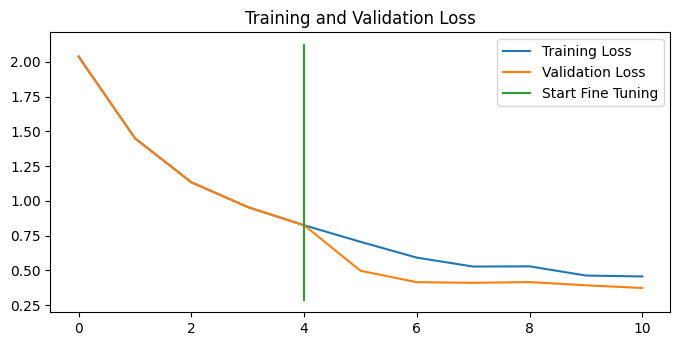

In [55]:
compare_histories(history_2, history_2_fine, initial_epochs)

## Model 4: Fine-tuning an existing model on all of the data

In [56]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2024-12-18 14:59:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  44.0MB/s    in 13s     

2024-12-18 14:59:31 (39.2 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [57]:
# Set up training and test dir
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [58]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

In [59]:
# Set up data inputs
import tensorflow as tf
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size = IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previos experiments (all experiments have used the same test dataset).

Let's verify this...

In [60]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 103s 1s/step - loss: 0.4392 - accuracy: 0.8564


[0.43915054202079773, 0.8564000129699707]

In [61]:
results_fine_tune_10_percent

[0.43915048241615295, 0.8564000129699707]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [62]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the
#10 percent data model was fine-tuned from
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)


In [63]:
# Let's evaluate model_2 again
model_2.evaluate(test_data)

79/79 [==============================] - 101s 1s/step - loss: 0.6596 - accuracy: 0.8332


[0.659563422203064, 0.8331999778747559]

In [65]:
# Check to see if our model_2 has been reverted back to feature extraction resutls
results_10_percent_data_aug

[0.6595634818077087, 0.8331999778747559]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the models weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 ayers of the base model unfrozen (model_3).
3. Saved the results and training log each time.
4. Reloaded the model from step 1 to do the same steps as step 2 excepts this time we're going to utse all the data (model_4)

In [66]:
# Check which layers are tunable in the who model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 True
3 global_average_pooling_layer True
4 output_layer True


In [68]:
# Let's drill into our base_model ans see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [69]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [70]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_4 = model_2.fit(train_data_10_classes_full,
                        epochs = fine_tune_epochs,
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        initial_epoch = history_2.epoch[-1],
                        callbacks = [create_tensorboard_callback(dir_name="tranfer_learning",
                                                                 experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: tranfer_learning/full_10_classes_fine_tune_last_10/20241218-154428
Epoch 5/10
235/235 [==============================] - 453s 2s/step - loss: 0.7093 - accuracy: 0.7736 - val_loss: 0.3936 - val_accuracy: 0.8651
Epoch 6/10
235/235 [==============================] - 442s 2s/step - loss: 0.6056 - accuracy: 0.8059 - val_loss: 0.3478 - val_accuracy: 0.8783
Epoch 7/10
235/235 [==============================] - 450s 2s/step - loss: 0.5440 - accuracy: 0.8235 - val_loss: 0.3360 - val_accuracy: 0.8865
Epoch 8/10
235/235 [==============================] - 447s 2s/step - loss: 0.5076 - accuracy: 0.8349 - val_loss: 0.2784 - val_accuracy: 0.9030
Epoch 9/10
235/235 [==============================] - 439s 2s/step - loss: 0.4814 - accuracy: 0.8403 - val_loss: 0.2787 - val_accuracy: 0.9013
Epoch 10/10
235/235 [==============================] - 435s 2s/step - loss: 0.4564 - accuracy: 0.8519 - val_loss: 0.2597 - val_accuracy: 0.9079


In [71]:
# Let's evaluat on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 108s 1s/step - loss: 0.2668 - accuracy: 0.9156


[0.2668241262435913, 0.9156000018119812]

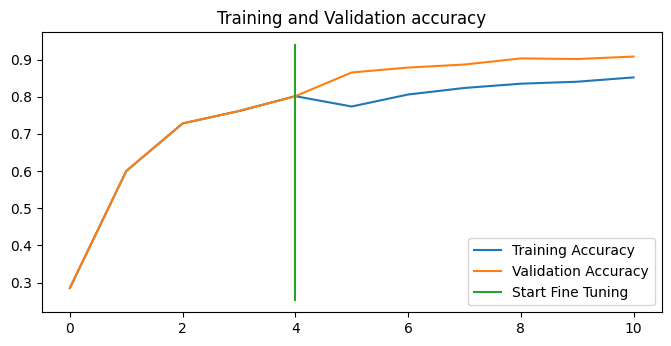

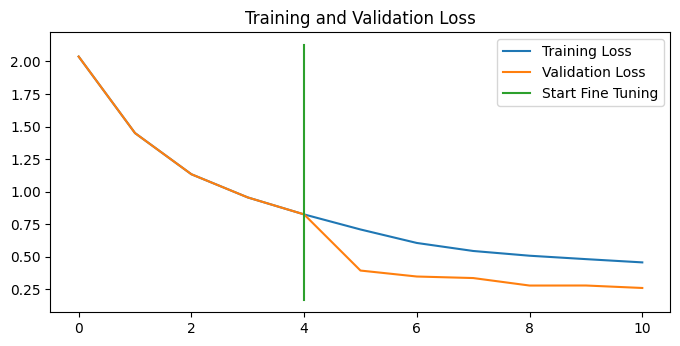

In [73]:
# How did fine-tuning go with more data?
compare_histories(history_2, history_4)